# Lending Club Prediction Models

The following was inspired by a very good yhat blog post that created a prediction model for Lending Club loans using R:
http://blog.yhathq.com/posts/machine-learning-for-predicting-bad-loans.html

The point of this exercise was to translate the yhat post into Python as much as possible and use sci-kit learn to evaluate several Machine Learning models.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import model_eval

pd.options.mode.chained_assignment = None

sns.set(color_codes=True)

%matplotlib inline

## Data Acquisition
Lending Club helpfully publishes anonymized loan data in csv format, which we'll use for this analysis.
You have to have a Lending Club log in to access the data, which is available here:
https://www.lendingclub.com/info/download-data.action

I've copied the files used in this analysis to a public Dropbox folder here:
https://dl.dropboxusercontent.com/u/12406727/Data/

To start, we'll load the files into a single pandas data frame:

In [8]:
# file_base_url = "https://dl.dropboxusercontent.com/u/12406727/Data/{0}"
file_base_url = '/Users/claus/Dropbox/Public/Data/{0}'

In [ ]:
files = ['LoanStats3a_securev1.csv', 
         'LoanStats3b_securev1.csv', 
         'LoanStats3c_securev1.csv', 
         'LoanStats3d_securev1.csv']

df = pd.DataFrame()

for f in files:
    d = pd.read_csv(file_base_url.format(f), low_memory=False, 
                          index_col='id', header=1, parse_dates=['issue_d'])
    print len(d)
    df = df.append(d)

In [9]:
output_file = file_base_url.format('LoanStats.csv')
df.to_csv(output_file,index=False)

In [17]:
data = df

In [10]:
print 'Records:', len(df)
# df.describe()

Records: 756887


## Data Prep & Cleanup

In [11]:
del data['desc']
del data['annual_inc_joint']
del data['dti_joint']
del data['verification_status_joint']

In [13]:
print len(data)

756887


In [14]:
# print 'Dropped columns:'

# for c in df.columns:
#     if c not in data.columns:
#         print '\t', c

In [18]:
data.columns

Index([u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv', u'term',
       u'int_rate', u'installment', u'grade', u'sub_grade', u'emp_title',
       u'emp_length', u'home_ownership', u'annual_inc', u'verification_status',
       u'issue_d', u'loan_status', u'pymnt_plan', u'url', u'purpose', u'title',
       u'zip_code', u'addr_state', u'dti', u'delinq_2yrs', u'earliest_cr_line',
       u'fico_range_low', u'fico_range_high', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'last_fico_range_high', u'last_fico_range_low',
       u'collections_12_mths_ex_med', u'mths_sin

### For members without prior records or delinquencies, we fill in 0s

In [21]:
prior_cols = ['delinq_2yrs', 
              'inq_last_6mths', 
              'mths_since_last_delinq', 
              'mths_since_last_record',
              'mths_since_last_major_derog'
             ]
for c in prior_cols:
    data.loc[:,c].fillna(0, inplace=True)

In [22]:
for c in prior_cols:
    print c, '\n\tRecords == 0: ', data.loc[data[c] == 0].member_id.count(), '\tNA records: ', data.loc[data[c].isnull()].member_id.count(), '\tType:', data[c].dtypes,'\n' 

delinq_2yrs 
	Records == 0:  613708 	NA records:  0 	Type: float64 

inq_last_6mths 
	Records == 0:  418335 	NA records:  0 	Type: float64 

mths_since_last_delinq 
	Records == 0:  392870 	NA records:  0 	Type: float64 

mths_since_last_record 
	Records == 0:  644243 	NA records:  0 	Type: float64 

mths_since_last_major_derog 
	Records == 0:  573628 	NA records:  0 	Type: float64 



### Tag bad loans

In [159]:
# data.groupby('last_fico_range_high').member_id.count();
# last_fico_range_high', 'last_fico_range_low

In [23]:
bad_indicators = ['Late (16-30 days)', 'Late (31-120 days)', 'Default', 'Charged Off']
# bad_indicators = ['Default', 'Charged Off']

In [24]:
# set is_bad indicator to true to loans in status with 'bad' indicators
data.loc[:,'is_bad'] = False
data.loc[data['loan_status'].isin(bad_indicators), 'is_bad'] = True
data.loc[data['loan_status'] == '', 'is_bad'] = np.nan

In [25]:
# how many bad loans overall?
print 'Total loans:\t', data.member_id.count()
print 'Bad loans:\t', data[data['is_bad']==True].member_id.count()
print 'Bad loan %:\t', data[data['is_bad']==True].member_id.count()*1./data.member_id.count()*1.

Total loans:	756878
Bad loans:	50514
Bad loan %:	0.0667399501637


## Data Type Cleanup

In [212]:
def convert_date(x):
    try:
        return pd.datetime.strptime(x, '%b-%Y')
    except:
        print x
        raise
        
# sometimes this necessary, sometimes not...probably depends on version of pandas installed
# dateparse = lambda x: convert_date(x)
# data.loc[:,'issue_d'] = data.issue_d.map(dateparse)

### Dates

In [26]:
data.loc[:,'issue_d'] = pd.to_datetime(data.issue_d)
data.loc[:,'year_issued'] = data.issue_d.dt.year
data.loc[:,'month_issued'] = data.issue_d.dt.month
data.loc[:,'earliest_cr_line'] = pd.to_datetime(data.earliest_cr_line)

In [27]:
from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [43]:
str(datetime.today().date())

'2015-11-29'

In [52]:
data.loc[:,'loan_age_days'] = data.issue_d.map(lambda x: days_between(str(datetime.date(x)), 
                                                                      str(datetime.today().date())
                                                                     )
                                               )

ValueError: time data '0001-255-255' does not match format '%Y-%m-%d'

### Numeric Features

In [214]:
data.loc[:,'revol_util_perc'] = data['revol_util'].str.replace("[%]", "").astype(float)

In [215]:
data[data['revol_util_perc'] > 100].member_id.count()

2793

In [216]:
data.loc[data['revol_util_perc'] > 100, 'revol_util_perc'] = 100

In [217]:
len(data)

756878

In [148]:
data.loan_amnt.dtypes

dtype('float64')

In [220]:
na_cols = ['last_fico_range_low', 
            'last_fico_range_high', 
            'fico_range_low', 
            'fico_range_high', 
            'loan_amnt', 
            'annual_inc', 
            'inq_last_6mths', 
            'open_acc', 
            'pub_rec', 
            'revol_bal', 
            'revol_util_perc', 
            'total_acc',
            'dti']

for c in na_cols:
    print c, '\n\tRecords == 0: ', data[data[c] == 0].member_id.count(), '\tNA records: ', data[data[c].isnull()].member_id.count(), '\tType:', data[c].dtypes,'\n' 

last_fico_range_low 
	Records == 0:  0 	NA records:  0 	Type: float64 

last_fico_range_high 
	Records == 0:  0 	NA records:  0 	Type: float64 

fico_range_low 
	Records == 0:  0 	NA records:  0 	Type: float64 

fico_range_high 
	Records == 0:  0 	NA records:  0 	Type: float64 

loan_amnt 
	Records == 0:  0 	NA records:  0 	Type: float64 

annual_inc 
	Records == 0:  0 	NA records:  0 	Type: float64 

inq_last_6mths 
	Records == 0:  414768 	NA records:  0 	Type: float64 

open_acc 
	Records == 0:  0 	NA records:  0 	Type: float64 

pub_rec 
	Records == 0:  636581 	NA records:  0 	Type: float64 

revol_bal 
	Records == 0:  2636 	NA records:  0 	Type: float64 

revol_util_perc 
	Records == 0:  3095 	NA records:  0 	Type: float64 

total_acc 
	Records == 0:  0 	NA records:  0 	Type: float64 

dti 
	Records == 0:  379 	NA records:  0 	Type: float64 



In [221]:
data = data.dropna(subset = na_cols)

data = data[(data['last_fico_range_low'] > 0) & 
            (data['last_fico_range_high'] > 0) &
            (data['fico_range_low'] > 0) & 
            (data['fico_range_high'] > 0) & 
            (data['loan_amnt'] > 0) & 
            (data['annual_inc'] > 0)
           ]

### Categorical Features

In [222]:
data.home_ownership = data.home_ownership.astype('category')
data.loc[:,'is_rent'] = False
data.loc[data['home_ownership'].isin(['RENT']), 'is_rent'] = True
data.loc[:,'fico_range_low'] = data.fico_range_low.astype('category')
data.loc[:,'fico_range_high'] = data.fico_range_high.astype('category')
data.loc[:,'last_fico_range_low'] = data.last_fico_range_low.astype('category')
data.loc[:,'last_fico_range_high'] = data.last_fico_range_high.astype('category')

In [223]:
data.loc[:,'fico_ordered_low'] = data.fico_range_low.astype('float')
data.loc[:,'fico_ordered_high'] = data.fico_range_high.astype('float')

In [224]:
data.grade = data.grade.astype('category')
data.loc[:,'grade_is_AB'] = False
data.loc[data['grade'].isin(['A', 'B']), 'grade_is_AB'] = True

### Dummy Features

In [225]:
grades = pd.get_dummies(data['grade'], prefix='grade')
data = data.join(grades)

In [175]:
sub_grades = pd.get_dummies(data['sub_grade'], prefix='sub_grade')
data = data.join(sub_grades)

In [176]:
# purposes = pd.get_dummies(data['purpose'], prefix='purpose')
# data = data.join(purposes)

In [177]:
# application_types = pd.get_dummies(data['application_type'], prefix='application_type')
# data = data.join(application_types)

In [178]:
# purposes.columns

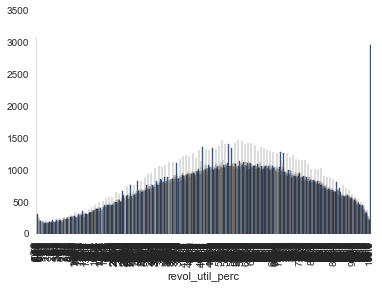

In [23]:
data.groupby('revol_util_perc').member_id.count().plot(kind='bar')

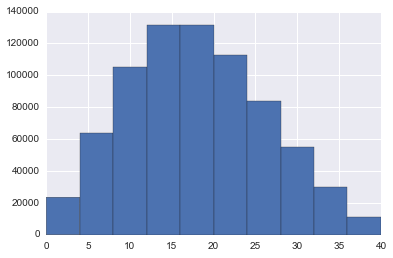

In [226]:
data['dti'].hist()

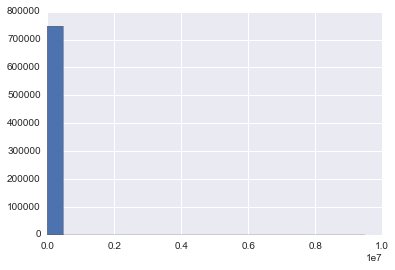

In [239]:
data['annual_inc'].hist(bins=20)

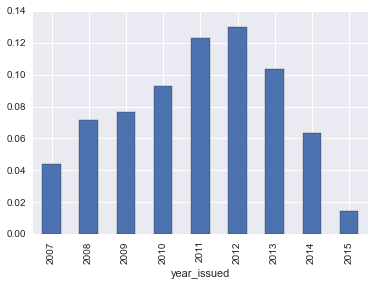

In [227]:
(data.groupby('year_issued').is_bad.sum()/data.groupby('year_issued').member_id.count()).plot(kind='bar')

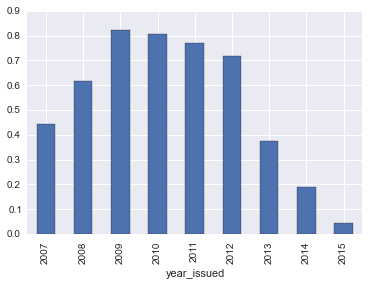

In [180]:
(data[data.loan_status == 'Fully Paid'].groupby('year_issued').member_id.count()/data.groupby('year_issued').member_id.count()).plot(kind='bar')

In [228]:
pd.crosstab(data.year_issued, data.loan_status)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Current,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
year_issued,,,,,,,,,,,
2007,20,0,0,39,0,193,201,0,0,0,0
2008,149,0,0,110,0,542,1284,0,0,0,0
2009,380,0,0,70,0,429,4067,0,0,0,0
2010,1102,274,0,187,15,708,9682,6,0,0,12
2011,2502,2191,1,0,0,0,16178,44,0,13,64
2012,6321,7549,8,0,0,0,37138,257,0,67,328
2013,11262,67988,47,0,0,0,49486,1262,0,388,1974
2014,9133,171781,80,0,0,0,44564,2556,0,982,4660
2015,831,270503,44,0,0,0,13042,2331,142,875,2469


In [ ]:
# ax = sns.boxplot(x="year_issued", y="fico_ordered", data=data.sort("year_issued"))

## Save to disk

In [85]:
data.to_csv('loans_cleaned.csv',index=False)
# data = pd.read_csv('loans_cleaned.csv', low_memory=False)

### Get only mature loans to make sure they had enough to be paid off 

In [229]:
mature_loans = data[data['year_issued'] == 2012]

In [230]:
print 'Total loans:\t', len(mature_loans)
print 'Bad loans:\t', len(mature_loans[mature_loans['is_bad']==True])
print 'Bad loan %:\t', len(mature_loans[mature_loans['is_bad']==True])*1./len(mature_loans)*1.

Total loans:	51668
Bad loans:	6724
Bad loan %:	0.130138577069


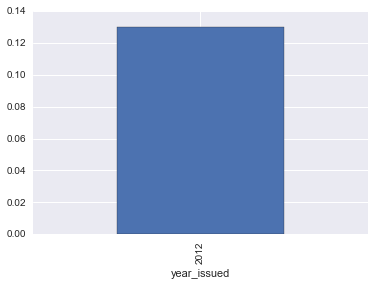

In [231]:
(mature_loans.groupby('year_issued').is_bad.sum()/mature_loans.groupby('year_issued').member_id.count()).plot(kind='bar')

In [115]:
# mature_loans.to_csv('loans_2012.csv',index=False)
# mature_loans = pd.read_csv('loans_2012.csv', low_memory=False)

In [ ]:
# mature_loans.describe()

In [232]:
feature_cols = ['loan_amnt', 'annual_inc', 'fico_range_low', 'fico_range_high', 
                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 
                'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
                'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 
                'last_fico_range_high', 'last_fico_range_low',
                'is_rent']

# features only available on new loans
# new_features = ['grade_is_AB',
# #                 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 
#                 'loan_amnt', 'annual_inc', 'fico_range_low', 
#                 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 
#                 'is_rent'
# #                 ,
# #                    'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
# #                    'purpose_educational', 'purpose_home_improvement', 'purpose_house',
# #                    'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
# #                    'purpose_other', 'purpose_renewable_energy',
# #                    'purpose_small_business', 'purpose_vacation', 'purpose_wedding'
#                ]

# 'last_fico_range_high', 'last_fico_range_low',
new_features = ['fico_range_low', 'dti','pub_rec', 'revol_util_perc',
                'inq_last_6mths', 'is_rent', 'loan_amnt', 'annual_inc' ]
label = ['is_bad']

In [ ]:
g = sns.pairplot(mature_loans[label+new_features])

In [184]:
X = mature_loans[new_features]
y = mature_loans[label]
print 'X:', X.shape
print 'y:', y.shape


X: (51668, 8)
y: (51668, 1)


In [91]:
X.describe();

### Scale numeric columns
We'll scale all numeric columns by adjusting them by their means and standard deviations.

In [200]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

X_scaled = pd.DataFrame(stdsc.fit_transform(X), columns=new_features)

ValueError: Shape of passed values is (2, 51668), indices imply (8, 51668)

In [91]:
y.head()

,is_bad
id,
1077501,0
1077430,1
1077175,0
1076863,0
1075358,0


## Prediction Modeling
We'll use sci-kit learn for all models, to create a model designed to predict whether a loan will be 'bad'. 

In [186]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
# print sklearn

import numpy as np
import matplotlib.pyplot as plt

### Let's try some basic logistic regression first

In [188]:
%%time
# C=1e3, 
# using CV log regression, which does stratified k-fold cv by default
model = LogisticRegressionCV(penalty='l2', class_weight='auto')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2)
    
#fit on training data
fit = model.fit(X_train, y_train.as_matrix().ravel())

print 'C: ', model.Cs

# predict on test data
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print "Accuracy of model:\t", accuracy
print 'MSE\t', metrics.mean_squared_error(y_test, y_pred)
print 'RMSE\t', np.sqrt(metrics.mean_squared_error(y_test, y_pred))

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print '\n'
print '-----------------------------------------'
print 'Scores:'
print '-----------------------------------------'
print 'Train\t', score_train
print 'Test\t', score_test
print '-----------------------------------------\n'

C:  10
Accuracy of model:	0.57664021676
MSE	0.42335978324
RMSE	0.650661035594


-----------------------------------------
Scores:
-----------------------------------------
Train	0.587966323124
Test	0.57664021676
-----------------------------------------

CPU times: user 592 ms, sys: 26.3 ms, total: 618 ms
Wall time: 610 ms


In [124]:
print model.class_weight

auto


In [189]:
cv = StratifiedKFold(y['is_bad'].values, n_folds=10)
scores = cross_val_score(model, X_scaled, y['is_bad'].values, cv=cv, scoring='accuracy', n_jobs=1, verbose=1)
score_cross_val_mean = scores.mean()
print 'Mean Cross-Val Score:', score_cross_val_mean

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.0s finished


Mean Cross-Val Score: 0.587078048176


[[5158 3883]
 [ 492  801]]
[[ 0.571  0.429]
 [ 0.381  0.619]]


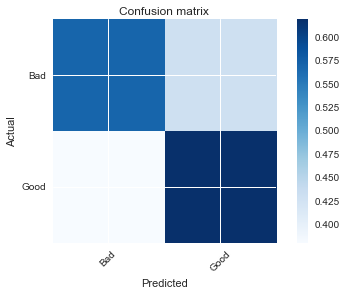

In [190]:
cm, cm_norm = model_eval.confusion_matrix(y_test, y_pred)

print cm
print cm_norm
model_eval.plot_confusion_matrix(cm_norm, labels=['Bad', 'Good'])
# test_score = model_eval.model_metrics(log, X, y, log_data_split)


In [191]:
print '\n'
print 'Coefficients for each X:\n'
coeff = pd.DataFrame(zip(new_features, model.coef_[0]), columns=['Feature', 'Weight'])
coeff['FeatureImportance'] = np.abs(coeff.Weight)/np.abs(coeff.Weight).sum()
coeff.sort_values(by='FeatureImportance', ascending=False)



Coefficients for each X:



,Feature,Weight,FeatureImportance
7,annual_inc,-0.405550,0.271000
0,fico_range_low,-0.391514,0.261620
6,loan_amnt,0.345921,0.231154
4,inq_last_6mths,0.192792,0.128829
1,dti,0.085167,0.056911
2,pub_rec,0.055538,0.037112
3,revol_util_perc,-0.016423,0.010974
5,is_rent,0.003592,0.002400


thresholds: [ 2.  1.  0.]
AUC: 0.595000835328


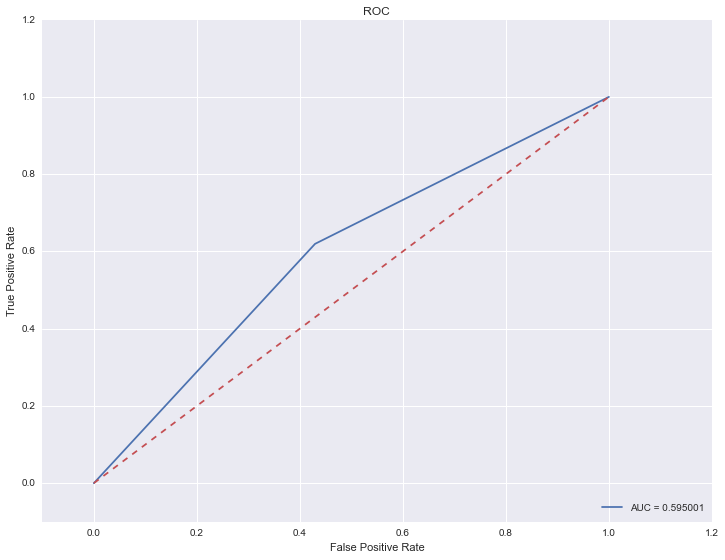

(array([ 0.   ,  0.429,  1.   ]),
 array([ 0.   ,  0.619,  1.   ]),
 array([ 2.,  1.,  0.]),
 0.59500083532841241)

In [192]:
model_eval.plot_roc(y_test, y_pred)

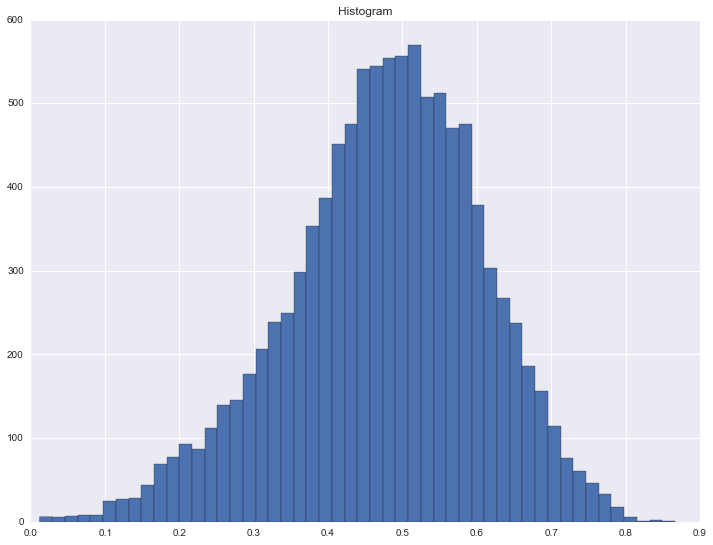

In [193]:
p = model.predict_proba(X_test)
model_eval.plot_histogram(p[:,1])

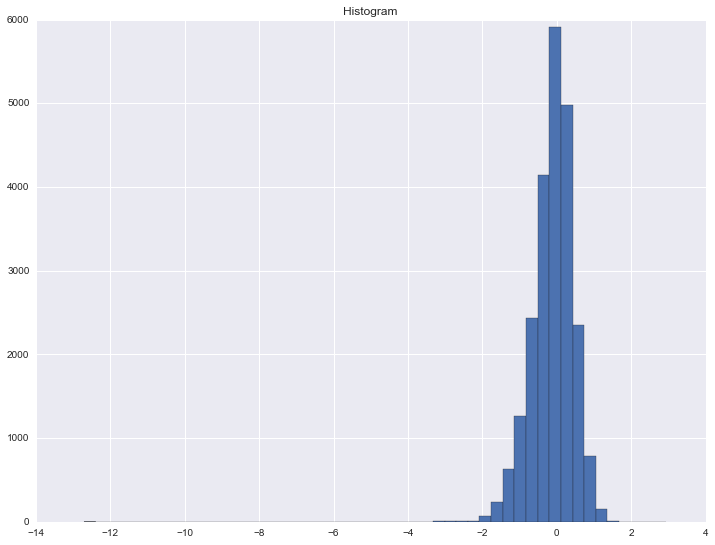

In [60]:
p = model.decision_function(X_test)
model_eval.plot_histogram(p)

## Multi-Label Logistic Regression

In [240]:
label = ['is_bad'] #loan_status'
features_small = ['loan_amnt', 'fico_range_low']
X = mature_loans[features_small]
y = mature_loans[label]
print 'X:', X.shape
print 'y:', y.shape

X: (51668, 2)
y: (51668, 1)


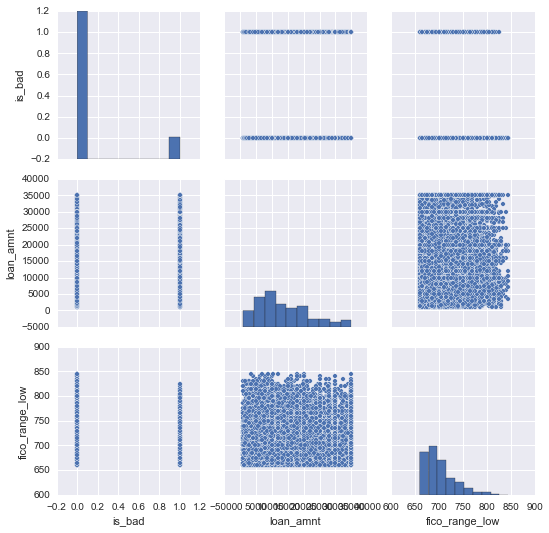

In [241]:
g = sns.pairplot(mature_loans[label+features_small])

In [242]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

X_scaled = pd.DataFrame(stdsc.fit_transform(X), columns=features_small)

In [243]:
%%time
# C=1e3, 
# using CV log regression, which does stratified k-fold cv by default
model = LogisticRegression(C=1e5, penalty='l2', class_weight='auto')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2)
    
#fit on training data
fit = model.fit(X_train, y_train.as_matrix().ravel())

# print 'C: ', model.Cs

# predict on test data
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print "Accuracy of model:\t", accuracy

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print '\n'
print '-----------------------------------------'
print 'Scores:'
print '-----------------------------------------'
print 'Train\t', score_train
print 'Test\t', score_test
print '-----------------------------------------\n'

Accuracy of model:	0.545093864912


-----------------------------------------
Scores:
-----------------------------------------
Train	0.547757294237
Test	0.545093864912
-----------------------------------------

CPU times: user 98.5 ms, sys: 11.2 ms, total: 110 ms
Wall time: 112 ms


### Random Forest

In [48]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.25)
    
#fit on training data
fit = model.fit(X_train, y_train)

# predict on test data
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print "Accuracy of model:\t", accuracy
print 'MSE\t', metrics.mean_squared_error(y_test, y_pred)
print 'RMSE\t', np.sqrt(metrics.mean_squared_error(y_test, y_pred))

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print '\n'
print '-----------------------------------------'
print 'Scores:'
print '-----------------------------------------'
print 'Train\t', score_train
print 'Test\t', score_test
print '-----------------------------------------\n'

Accuracy of model:	0.93325020041
MSE	0.0667497995903
RMSE	0.258359825806


-----------------------------------------
Scores:
-----------------------------------------
Train	0.994554728835
Test	0.93325020041
-----------------------------------------

CPU times: user 6.3 s, sys: 156 ms, total: 6.46 s
Wall time: 2.32 s


/Users/claus/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
# # 0.977352599188
# p = model.predict_proba(X_test)
# model_eval.plot_histogram(p[:,1])

In [ ]:
# plot_roc(rf_data_split['y_test'], rf_y_score)
print pd.DataFrame(zip(new_features, model.feature_importances_)).sort(1, ascending=False)

In [ ]:
model_eval.plot_roc(y_test, y_pred)

## SVM

In [245]:
label = ['is_bad'] #loan_status'
features_small = ['loan_amnt', 'fico_range_low']
X = mature_loans[features_small]
y = mature_loans[label]
print 'X:', X.shape
print 'y:', y.shape

X: (51668, 2)
y: (51668, 1)


In [246]:
stdsc = StandardScaler()

X_scaled = pd.DataFrame(stdsc.fit_transform(X), columns=features_small)

In [249]:
%%time
from sklearn import svm
model = svm.LinearSVC(class_weight='auto')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.25)
    
#fit on training data
fit = model.fit(X_train, y_train)

# predict on test data
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print "Accuracy of model:\t", accuracy
print 'MSE\t', metrics.mean_squared_error(y_test, y_pred)
print 'RMSE\t', np.sqrt(metrics.mean_squared_error(y_test, y_pred))

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print '\n'
print '-----------------------------------------'
print 'Scores:'
print '-----------------------------------------'
print 'Train\t', score_train
print 'Test\t', score_test
print '-----------------------------------------\n'

Accuracy of model:	0.536579701169
MSE	0.463420298831
RMSE	0.680749806339


-----------------------------------------
Scores:
-----------------------------------------
Train	0.54406337901
Test	0.536579701169
-----------------------------------------

CPU times: user 2.14 s, sys: 25.9 ms, total: 2.17 s
Wall time: 2.25 s


/Users/claus/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  converted to the first listed format.


[[11218     0]
 [ 1699     0]]
[[ 1.  0.]
 [ 1.  0.]]


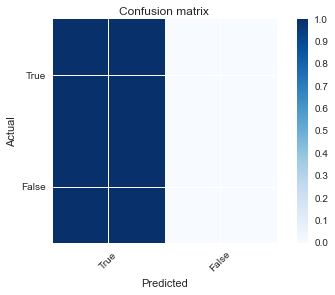

In [248]:
cm, cm_norm = model_eval.confusion_matrix(y_test, y_pred)

print cm
print cm_norm
model_eval.plot_confusion_matrix(cm_norm)

thresholds: [ 2.  1.  0.]
AUC: 0.827906941061


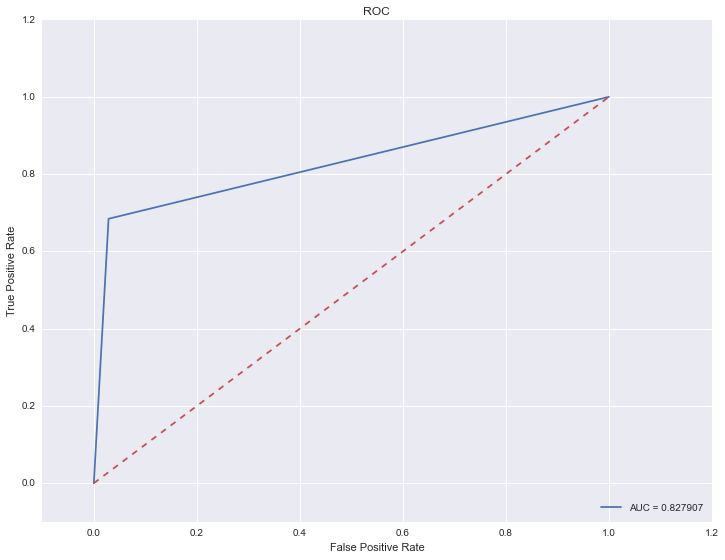

(array([ 0.   ,  0.029,  1.   ]),
 array([ 0.   ,  0.684,  1.   ]),
 array([ 2.,  1.,  0.]),
 0.82790694106076734)

In [51]:
model_eval.plot_roc(y_test, y_pred)

In [ ]:
print '\n'
print 'Coefficients for each X:\n'
coeff = pd.DataFrame(zip(new_features, model.coef_[0]), columns=['Feature', 'Weight'])
coeff['FeatureImportance'] = np.abs(coeff.Weight)/np.abs(coeff.Weight).sum()
coeff.sort_values(by='FeatureImportance', ascending=False)

## Gradient Boosted Regression Tree

In [ ]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=1000, max_features=1.0, learning_rate=0.01, 
                                    max_depth=4, min_samples_leaf=5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.25)
    
#fit on training data
fit = model.fit(X_train, y_train)

# predict on test data
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print "Accuracy of model:\t", accuracy
print 'MSE\t', metrics.mean_squared_error(y_test, y_pred)
print 'RMSE\t', np.sqrt(metrics.mean_squared_error(y_test, y_pred))

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print '\n'
print '-----------------------------------------'
print 'Scores:'
print '-----------------------------------------'
print 'Train\t', score_train
print 'Test\t', score_test
print '-----------------------------------------\n'

In [ ]:
print pd.DataFrame(zip(new_features, model.feature_importances_)).sort(1, ascending=False)

In [ ]:
p = gb.predict_proba(data_split['X_test'])
plot_histogram(p[:,1])